In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
import random
import re
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Bidirectional, MaxPool1D, concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, schedules

from keras import regularizers
import os
import glob

In [ ]:
# Extract audio files to tmp folder
!unzip '/content/drive/MyDrive/Deep Learning Alg/Final Proj/RAVDESS_data_emotion.zip' -d '/tmp/Audio_RAVDESS'
!unzip '/content/drive/MyDrive/Deep Learning Alg/Final Proj/RAVDESS_data_emotion_Songs.zip' -d '/tmp/Audio_RAVDESS_Songs'
!unzip '/content/drive/MyDrive/Deep Learning Alg/Final Proj/SAVEE_data_emotion.zip' -d '/tmp/SAVEE_AudioData'

In [ ]:
PATH = ["/tmp/Audio_RAVDESS/data/Actor_*/*.wav", '/tmp/Audio_RAVDESS_Songs/Actor_*/*.wav',"/tmp/SAVEE_AudioData/AudioData/*/*.wav"]
mylist=[]
mylist_paths=[]
for p in range(len(PATH)):
    print('Pulling Files from dir : ' + PATH[p])     
    for file in glob.glob(PATH[p]):           
        mylist.append(file)   

for index, y in enumerate(mylist):
   mylist_paths.append(y)

# Setting up Labels

In [6]:
RAVDESS_Emo = {
    '03':'happy',
    '04':'sad'
}

SAVEE_Emo = {
    'h':'happy',
    'sa':'sad'
}

feeling_list=[]

for item in range(len(mylist_paths)):
  if 'RAVDESS' in mylist_paths[item]:  
    for file in glob.glob(mylist_paths[item]):
        basename = os.path.basename(file)
        emotion = basename.split("-")[2]         
        if emotion in RAVDESS_Emo:
            if emotion == '03':
                 feeling_list.append(RAVDESS_Emo.get(emotion))
            elif emotion == '04':
                feeling_list.append(RAVDESS_Emo.get(emotion))    
     

  if 'SAVEE' in mylist_paths[item]:  
    for file in glob.glob(mylist_paths[item]):              
        file_components = file.split('/')
        file_name = file_components[-1].split('.')
        emotion_code = re.sub('\d','',file_name[0])  
        if  emotion_code in SAVEE_Emo:
            if emotion_code == 'h':
                 feeling_list.append(SAVEE_Emo.get(emotion_code)) 
            elif emotion_code == 'sa':
                 feeling_list.append(SAVEE_Emo.get(emotion_code))
           

Sanity Check Labels

In [7]:
labels = pd.DataFrame(feeling_list, columns=['labels'])

In [8]:
y = set(feeling_list)
y

{'happy', 'sad'}

In [9]:
labels[:10]

,labels
0,sad
1,sad
2,happy
3,happy
4,sad
5,happy
6,sad
7,happy
8,sad
9,happy


# Getting the features of audio files using librosa

In [27]:
RAVDESS_Emo = {
    '01',
    '02',
    '05',
    '06',
    '07',
    '08'
}


SAVEE_Emo = {
    'a',
    'c',
    'f',    
    'n',  
    'd',
    'su',
}

df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist_paths):
    if 'RAVDESS' in mylist_paths[index]:      
       for file in glob.glob(mylist_paths[index]):
          basename = os.path.basename(file)
          emotion = basename.split("-")[2]            
          if emotion not in RAVDESS_Emo: 
                X, sample_rate = librosa.load(y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
                sample_rate = np.array(sample_rate)
                mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                                    sr=sample_rate, 
                                                    n_mfcc=13),
                                axis=0)
                feature = mfccs
                #[float(i) for i in feature]
                #feature1=feature[:135]
                df.loc[bookmark] = [feature]
                bookmark=bookmark+1   
          

    if 'SAVEE' in mylist_paths[index]:
        for file in glob.glob(mylist_paths[index]):              
              file_components = file.split('/')
              file_name = file_components[-1].split('.')
              emotion_code = re.sub('\d','',file_name[0])        
              if emotion_code not in SAVEE_Emo:   
                  X, sample_rate = librosa.load(y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
                  sample_rate = np.array(sample_rate)
                  mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                                      sr=sample_rate, 
                                                      n_mfcc=13),
                                  axis=0)
                  feature = mfccs
                  #[float(i) for i in feature]
                  #feature1=feature[:135]
                  df.loc[bookmark] = [feature]
                  bookmark=bookmark+1       

Sanity check extracted features 

In [28]:
df[:5]

,feature
0,"[-52.01556, -53.926857, -55.110825, -53.355915..."
1,"[-55.158813, -52.792152, -52.665127, -52.97408..."
2,"[-51.307365, -51.045193, -52.16156, -48.928867..."
3,"[-41.22146, -41.22146, -41.126522, -41.22146, ..."
4,"[-49.759026, -47.63607, -46.94962, -48.07526, ..."


In [29]:
df3 = pd.DataFrame(df['feature'].values.tolist())
df3 = df3.fillna(0)

In [30]:
df3[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-52.015560,-53.926857,-55.110825,-53.355915,-52.040325,-49.672298,-49.241959,-52.012478,-53.579514,-50.573036,-49.471855,-51.367714,-52.232018,-54.462620,-55.838707,-57.235474,-55.562435,-55.120850,-54.064377,-54.143757,-54.567852,-53.837864,-52.962357,-54.040573,-55.627159,-56.008652,-54.077217,-53.454628,-52.737514,-53.558735,-54.311516,-52.079636,-52.049049,-51.275154,-46.978233,-41.998024,-43.466545,-40.963722,-38.218079,-37.587780,...,-48.159451,-47.816895,-48.394680,-49.938534,-50.981121,-49.747360,-50.013405,-48.893723,-48.023945,-50.757603,-52.036850,-51.126205,-52.521248,-55.364464,-52.297024,-49.091721,-46.470577,-47.519371,-51.314548,-52.921658,-52.269741,-50.403999,-52.134762,-52.546688,-49.469322,-47.856403,-48.843246,-49.341145,-51.087746,-52.256901,-52.028164,-50.795773,-52.250607,-51.284134,-51.056587,-51.108585,-50.111050,-50.283268,-51.438297,-52.828003
1,-55.158813,-52.792152,-52.665127,-52.974079,-54.078026,-55.675396,-53.966305,-51.444279,-49.399868,-48.839806,-47.274067,-48.332092,-50.031548,-50.187309,-52.522190,-52.298584,-48.250313,-47.975708,-50.194614,-49.388908,-49.481682,-49.059711,-51.000023,-50.693073,-50.951607,-53.357651,-57.236816,-54.451664,-54.460506,-54.093666,-52.967918,-55.632729,-54.024483,-53.305504,-53.828835,-50.354607,-48.019348,-47.913960,-48.407955,-50.582153,...,-30.523302,-24.875034,-25.472816,-29.080845,-30.982683,-32.810081,-32.350128,-33.780449,-34.134998,-33.618774,-32.432011,-32.634884,-32.607880,-33.287560,-34.713478,-35.797726,-37.907021,-33.550999,-29.819609,-29.289572,-30.098045,-31.905100,-34.133781,-35.257835,-37.778976,-39.228695,-38.756741,-39.621609,-40.489494,-39.291935,-41.066181,-44.088711,-43.914719,-43.892006,-46.027889,-47.563152,-47.620422,-50.008160,-48.566013,-52.263718
2,-51.307365,-51.045193,-52.161560,-48.928867,-48.199196,-49.030579,-50.739254,-51.606083,-51.465927,-51.132683,-49.016880,-48.402115,-49.765903,-50.425858,-49.024410,-49.980442,-51.109047,-50.009640,-49.089256,-48.830135,-49.177994,-49.812576,-48.221684,-49.115078,-48.085911,-48.974392,-50.336399,-49.589371,-47.116421,-50.239433,-51.727921,-51.717083,-52.020889,-51.231548,-47.894852,-46.017490,-46.081295,-45.963352,-46.379299,-45.884159,...,-45.443504,-45.926559,-49.608860,-47.827873,-46.823738,-46.093117,-45.408150,-45.827244,-44.855812,-45.884151,-47.547195,-45.036873,-44.336670,-46.241917,-47.417362,-47.169292,-48.414371,-49.380795,-47.456741,-48.351505,-46.081490,-45.445461,-45.421013,-47.001328,-45.927158,-44.851055,-45.672646,-47.419941,-47.058994,-45.835083,-46.833023,-46.321636,-47.316433,-47.622066,-48.562630,-50.442257,-49.990582,-47.865288,-46.450462,-45.670261
3,-41.221458,-41.221458,-41.126522,-41.221458,-41.221458,-41.221458,-41.221458,-41.221458,-40.726543,-41.221458,-41.221458,-41.221458,-41.221458,-41.221458,-41.221458,-41.221458,-41.221458,-41.221458,-41.221458,-41.221458,-41.221458,-40.861740,-40.063755,-41.221458,-41.221458,-41.207882,-41.221458,-41.221458,-41.221458,-41.103153,-40.289593,-40.433636,-41.221458,-40.718811,-40.572624,-41.221458,-41.221458,-40.909569,-41.221458,-41.221458,...,-28.875378,-29.739971,-31.622335,-32.597748,-33.202343,-34.573528,-35.114380,-33.294693,-35.275875,-37.637745,-37.540230,-38.392635,-39.359165,-38.782997,-36.560368,-37.722439,-37.198456,-32.661476,-26.391094,-22.757679,-20.738678,-23.188534,-25.555622,-25.177975,-26.508345,-26.001417,-26.231041,-27.977125,-31.714571,-30.523457,-31.140036,-32.166107,-35.480412,-34.864799,-32.722271,-34.464897,-34.459141,-35.890823,-31.993696,-25.662676
4,-49.759026,-47.636070,-46.949619,-48.075260,-48.023857,-49.006367,-52.525120,-53.639114,-50.583111,-50.311222,-51.017845,-52.012642,-50.916889,-49.275612,-49.059425,-51.285763,-51

# Matching the labels position in text w/ label position for audio

In [14]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) #0-Negative 1-Positive

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [31]:
def sort_shuffle_feats_and_labels(xfeat, xlbls, yfeat, ylbls):
  
    r = random.randint(0, yfeat.shape[0])    

    # Scale sample size down to shape of yfeat and ylbls
    xfeat = xfeat[ : yfeat.shape[0]]
    xlbls = xlbls[: ylbls.shape[0]]   

    # set text data / labels  to DF to sort in ascending order by label
    xlbls = pd.DataFrame( xlbls, columns=['text_labels'])
    xfeat = pd.DataFrame(xfeat, columns=['text_features'])
    df_txt_lbls = pd.concat([xfeat , xlbls], axis=1)
    df_txt_lbls = df_txt_lbls.sort_values(['text_labels'], ascending=True)
    df_txt_lbls = df_txt_lbls.reset_index(drop=True)    

    # set audio data / labels  to DF to sort in ascending order by label        
    ylbls = encoded_labels(ylbls) 
    ylbls = pd.DataFrame(ylbls, columns=['audio_labels'])          
    df_audio_feat_lbls = pd.concat([yfeat,  ylbls], axis=1)
    df_audio_feat_lbls = df_audio_feat_lbls.sort_values(['audio_labels'], ascending=True)
    df_audio_feat_lbls = df_audio_feat_lbls.reset_index(drop=True)   
    
    # shuffle dataframe on the same random state
    df_txt_lbls = shuffle(df_txt_lbls, random_state=r)
    df_audio_feat_lbls = shuffle(df_audio_feat_lbls, random_state=r) 

    # split dataframes into feature and label sets
    X_train_txt =   df_txt_lbls.iloc[:,:-1]
    y_train_txt =   df_txt_lbls.iloc[:,-1:]

    X_train_audio = df_audio_feat_lbls.iloc[:,:-1]
    y_train_audio = df_audio_feat_lbls.iloc[:,-1:]

    # reshape text data / labels back to 1D tensor
    X_train_txt = X_train_txt.values
    X_train_txt = X_train_txt.reshape(X_train_txt.shape[0])

    y_train_txt = y_train_txt.values
    y_train_txt = y_train_txt.reshape(y_train_txt.shape[0])

    return X_train_txt, y_train_txt ,X_train_audio,  y_train_audio     


def encoded_labels(labels):
      emotion_encoder = {
      'sad':0,
      'happy':1    
    }
      list_encoded = [ emotion_encoder.get(values[0]) for name, values  in labels.iterrows()]     
      return list_encoded

def decoded_labels(labels):
      emotion_decoder = {
      0:'sad',
      1:'happy'   
    }      
      df_encoded_lbls = pd.DataFrame(labels)
      list_decoded = [ emotion_decoder.get(values[0]) for name, values  in  df_encoded_lbls.iterrows()]
      return list_decoded

In [32]:
label_matching_text = train_labels.copy()
train_data_matching_text = train_data.copy()

X_train_txt, y_train_txt,  X_train_audio ,y_train_audio = sort_shuffle_feats_and_labels(train_data_matching_text, label_matching_text, df3, labels)

Sanity check of the newly re-arranged data

In [ ]:
# display(X_train_txt) 
# display(y_train_txt) 
display(X_train_audio) 
# display(y_train_audio)  


In [ ]:
X_train_audio.isna().sum()

# Prep training, testing, and validation datasets

In [19]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results


def prepare_imdb_dataset(test_size, val_size, random_state, 
                         adjust_Train_sample=False, 
                         adjust_Test_sample=False,
                         adjust_Val_sample=False , 
                         train_shape=None, 
                         test_shape=None,
                         val_shape=None,
                         lstm=False):

    xTrain, xTest, yTrain, yTest = train_test_split(X_train_txt, y_train_txt, train_size=test_size, random_state=random_state, shuffle=False)

    xTrain, xVal, yTrain, yVal = train_test_split(xTrain,  yTrain, test_size=val_size, random_state=random_state, shuffle=False)
    xTrain=np.array(xTrain)
    # Our vectorized training data
    x_train_text = vectorize_sequences(xTrain)    
    # Our vectorized test data
    x_test_text = vectorize_sequences(xTest)
    # Our vectorized test data
    x_val_text = vectorize_sequences(xVal)
   

    # Our vectorized labels
    y_train_text = np.asarray(yTrain).astype('float32')
    y_test_text= np.asarray(yTest).astype('float32')
    y_val_text= np.asarray(yVal).astype('float32')

    if adjust_Train_sample:
      x_train_text = x_train_text[: train_shape]
      y_train_text = y_train_text[: train_shape]
      if lstm:
           x_train_text = x_train_text[..., np.newaxis]
           y_train_text = y_train_text[..., np.newaxis]


    if adjust_Test_sample:
      x_test_text = x_test_text[:test_shape]
      y_test_text = y_test_text[:test_shape]
      if lstm:
        x_test_text = x_test_text[..., np.newaxis]
        y_test_text = y_test_text[..., np.newaxis]

    if adjust_Val_sample:
      x_val_text = x_val_text[:val_shape]     
      y_val_text = y_val_text[:val_shape]
      if lstm:
        x_val_text = x_val_text[..., np.newaxis]     
        y_val_text = y_val_text[..., np.newaxis] 

    return x_train_text, x_val_text, x_test_text , y_train_text, y_val_text,y_test_text

In [73]:
 X_train, X_test, y_train, y_test =train_test_split(X_train_audio, y_train_audio, train_size=0.83, random_state=None, shuffle=False)
 X_train, X_val, y_train, y_val =train_test_split( X_train, y_train, test_size=0.1, random_state=None,shuffle=False)

In [74]:
x_trainapi = X_train.copy()
x_testapi = X_test.copy()
x_valapi = X_val.copy()

x_trainapi = np.expand_dims(x_trainapi, axis=2)
x_testapi = np.expand_dims(x_testapi, axis=2)
x_valapi = np.expand_dims(x_valapi, axis=2)

In [75]:
xTrain_text, xVal_text, xTest_text, yTrain_text, yVal_text,yTest_text = prepare_imdb_dataset(test_size=0.83, 
                                                                                              val_size=0.1, 
                                                                                              random_state=None,
                                                                                              adjust_Train_sample=True, 
                                                                                              adjust_Test_sample=True,
                                                                                              adjust_Val_sample=True,
                                                                                              train_shape=x_trainapi.shape[0], 
                                                                                              test_shape=x_testapi.shape[0],
                                                                                              val_shape=x_valapi.shape[0],
                                                                                              lstm =False
                                                                                              )

In [76]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

# Functional API model one output with synced labels

In [77]:
text_input_shape = (xTrain_text.shape[1],)
audio_input_shape = (x_trainapi.shape[1], x_trainapi.shape[2])

In [80]:
# Text Input / Processing Layer
text_input_shape = text_input_shape
text_input = Input(shape=text_input_shape, dtype='float32', name='text')

dense_layer_1 = Dense(16,activation='relu')(text_input)
dense_layer_2 = Dense(16,activation='relu')(dense_layer_1)
drop_out_text = Dropout(0.3)(dense_layer_2)
results = Dense(1,activation='sigmoid')(drop_out_text) #83% acc
# results = Dense(2,activation='sigmoid')(drop_out_text) 82% acc

# Sound Input / Processing layer
audio_input_shape = audio_input_shape
audio_input = Input(shape=audio_input_shape, name='audio')
feat_extrct1_audio = Conv1D(128,5, activation='relu',padding='same')(audio_input)    
feat_extrct2_audio = Conv1D(128,5, activation='relu',padding='same')(feat_extrct1_audio)  
feat_extrct3_audio = Conv1D(128,5, activation='relu',padding='same')(feat_extrct2_audio)  
drop_out_audio = Dropout(0.1)(feat_extrct3_audio)
max_pool_audio = MaxPool1D(pool_size=(8))(drop_out_audio)
feat_extrct4_audio = Conv1D(128,5,activation='relu',padding='same')(max_pool_audio)    
flatten_audio =Flatten()(feat_extrct4_audio)
dense_audio_1 = Dense(16, activation='relu')(flatten_audio)
dense_dropout = Dropout(0.3)(dense_audio_1 )
dense_audio_ans = Dense(2, activation='softmax')(dense_dropout)

#concatenate layers
concat_layers = concatenate([results, dense_audio_ans], axis=-1)
answer = Dense(2,activation='softmax')(concat_layers)

#compile model
model_funct_2in_1out = Model([text_input, audio_input], answer)
optimizer = Adam(learning_rate=1e-5)
model_funct_2in_1out.compile(optimizer=optimizer , loss='binary_crossentropy', metrics=['accuracy'])
model_funct_2in_1out.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
audio (InputLayer)              [(None, 216, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 216, 128)     768         audio[0][0]                      
__________________________________________________________________________________________________
conv1d_57 (Conv1D)              (None, 216, 128)     82048       conv1d_56[0][0]                  
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 216, 128)     82048       conv1d_57[0][0]                  
___________________________________________________________________________________________

In [81]:
apihistory=model_funct_2in_1out.fit([xTrain_text , x_trainapi],  y_train, batch_size=32, epochs=250, validation_data=([xTest_text, x_testapi], y_test))

Epoch 1/250
21/21 [==============================] - 1s 22ms/step - loss: 0.7112 - accuracy: 0.4981 - val_loss: 0.6976 - val_accuracy: 0.5101
Epoch 2/250
21/21 [==============================] - 0s 12ms/step - loss: 0.7063 - accuracy: 0.5010 - val_loss: 0.6943 - val_accuracy: 0.5436
Epoch 3/250
21/21 [==============================] - 0s 13ms/step - loss: 0.6957 - accuracy: 0.5370 - val_loss: 0.6952 - val_accuracy: 0.5235
Epoch 4/250
21/21 [==============================] - 0s 12ms/step - loss: 0.6994 - accuracy: 0.5032 - val_loss: 0.6911 - val_accuracy: 0.5906
Epoch 5/250
21/21 [==============================] - 0s 11ms/step - loss: 0.6973 - accuracy: 0.5048 - val_loss: 0.6909 - val_accuracy: 0.5570
Epoch 6/250
21/21 [==============================] - 0s 11ms/step - loss: 0.6905 - accuracy: 0.5631 - val_loss: 0.6883 - val_accuracy: 0.5101
Epoch 7/250
21/21 [==============================] - 0s 12ms/step - loss: 0.6924 - accuracy: 0.5608 - val_loss: 0.6877 - val_accuracy: 0.5973
Epoch 

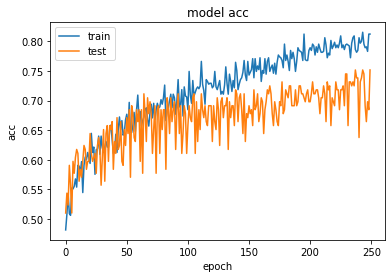

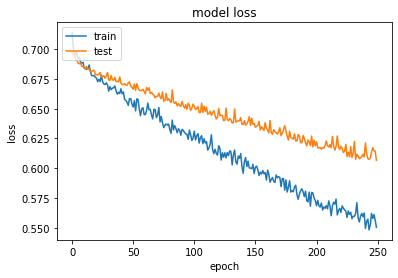

In [82]:
plt.plot(apihistory.history['accuracy'])
plt.plot(apihistory.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(apihistory.history['loss'])
plt.plot(apihistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
score = model_funct_2in_1out.evaluate([xVal_text, x_valapi], y_val, verbose=0)
print("%s: %.2f%%" % (model_funct_2in_1out.metrics_names[1], score[1]*100))

accuracy: 67.12%


## Predicting emotions on the test data

In [93]:
preds = model_funct_2in_1out.predict([xVal_text, x_valapi], 
                         batch_size=32, 
                         verbose=1)

3/3 [==============================] - 0s 5ms/step


In [94]:
preds

array([[0.41086796, 0.589132  ],
       [0.21646051, 0.7835395 ],
       [0.6196713 , 0.38032869],
       [0.27479434, 0.7252057 ],
       [0.48373076, 0.51626927],
       [0.60149646, 0.39850354],
       [0.40915912, 0.5908409 ],
       [0.76234454, 0.2376555 ],
       [0.6843233 , 0.31567672],
       [0.62064487, 0.37935513],
       [0.4701718 , 0.5298282 ],
       [0.7915239 , 0.20847608],
       [0.7501938 , 0.24980626],
       [0.7790695 , 0.22093052],
       [0.7587487 , 0.2412513 ],
       [0.4092827 , 0.5907173 ],
       [0.8252586 , 0.17474136],
       [0.22670287, 0.77329713],
       [0.256484  , 0.743516  ],
       [0.7460064 , 0.2539936 ],
       [0.7268197 , 0.27318028],
       [0.72293794, 0.2770621 ],
       [0.26134858, 0.73865145],
       [0.8457639 , 0.15423606],
       [0.6116588 , 0.38834116],
       [0.30184755, 0.6981525 ],
       [0.32375178, 0.67624825],
       [0.28517416, 0.71482587],
       [0.782632  , 0.21736807],
       [0.8187963 , 0.18120374],
       [0.

In [95]:
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (decoded_labels(abc))

In [87]:
# preds1 = [round(x[0]) for x in preds]
# abc = preds1
# predictions = (decoded_labels(abc))

In [96]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,happy
1,happy
2,sad
3,happy
4,happy
5,sad
6,happy
7,sad
8,sad
9,sad


In [97]:
actual=y_val.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (decoded_labels(abc123))

In [90]:
# abc123 = [int(x) for x in yVal_text]
# actualvalues = (decoded_labels(abc123))

In [98]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,happy
1,happy
2,sad
3,happy
4,sad
5,happy
6,sad
7,sad
8,happy
9,happy


In [99]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [100]:
finaldf[0:20]

,actualvalues,predictedvalues
0,happy,happy
1,happy,happy
2,sad,sad
3,happy,happy
4,sad,happy
5,happy,sad
6,sad,happy
7,sad,sad
8,happy,sad
9,happy,sad


In [101]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
happy,32
sad,41


In [102]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
happy,30
sad,43


## Confusion Matrix

In [103]:
confu_labels = ['happy','sad']

In [104]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(width, center, matrix, labels):
      wid = width
      cen = center

      for k in  range(len(labels)):
        print(str().rjust(width) + labels[k], end='')

      for i in range(len(matrix)):  
        print('\n')
        s = ''  
        for j in matrix[i]:    
          s +=  str(j).center(cen)
          s +=str().center(cen)     
        print(labels[i] +str().center(cen)+ s)  
        
        audio_predict = confusion_matrix(actual,  preds1)
        create_confusion_matrix(6,4,audio_predict, confu_labels)

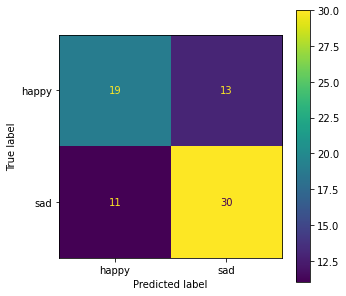

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(actualvalues,  predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=confu_labels)
ax.set_xticklabels([''] + confu_labels)
ax.set_yticklabels([''] + confu_labels)
disp.plot(ax=ax) 

In [151]:
model_funct_2in_1out.save('model_funct_2in_1out_67acc_slightly_beter.h5')

# Live Demo Testing

In [107]:
!pip install ffmpeg-python
!pip install SpeechRecognition

     |████████████████████████████████| 32.8MB 93kB/s 


## Recording and Saving Audio to .wav file

In [109]:
"""
Original Source for this code: https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read, write
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]
  
  sr, audio = wav_read(io.BytesIO(riff))

 
  write("example.wav", sr, audio)


  return audio, sr

In [215]:
audio, sr = get_audio()

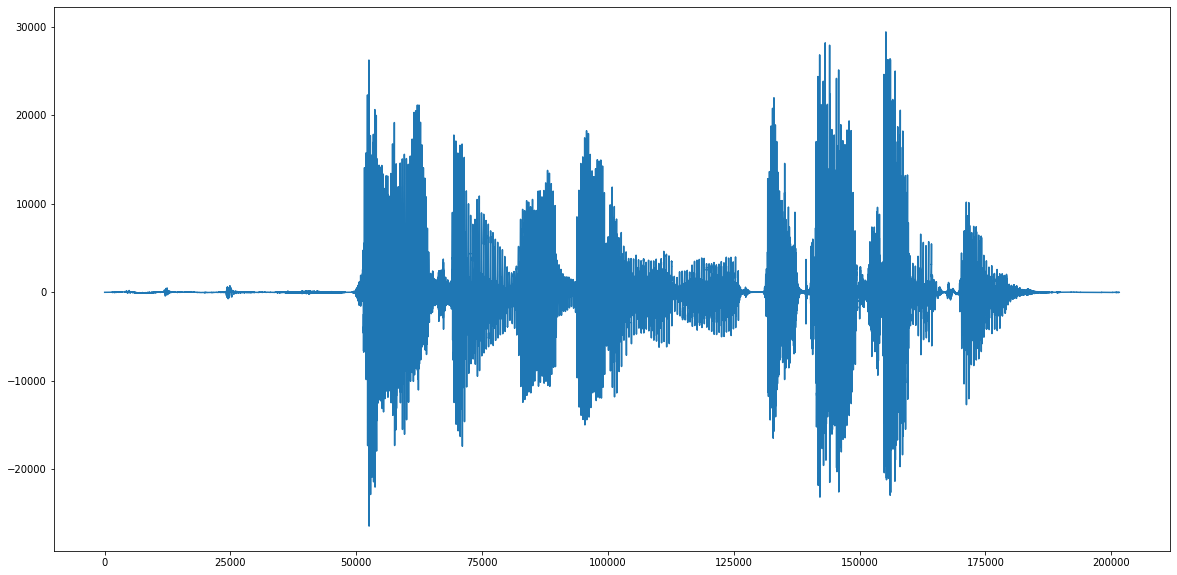

In [216]:
plt.figure(figsize=(20,10))
plt.plot(audio)
plt.show()

## Transcribing Audio file to text/string

In [217]:
""" 
Source for transcribing audio: https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html
"""
#import library
import speech_recognition as sr

# Initialize recognizer class (for recognizing the speech)
r = sr.Recognizer()

# Reading Audio file as source
# listening the audio file and store in audio_text variable

with sr.AudioFile('/content/example.wav') as source:
    
    audio_text = r.listen(source)
    
# recoginize_() method will throw a request error if the API is unreachable, hence using exception handling
    try:
        
        # using google speech recognition
        text = r.recognize_google(audio_text)
        print('Converting audio transcripts into text ...')
        print(text)
     
    except:
         print('Sorry.. run again...')

Converting audio transcripts into text ...
hey I'm feeling really better right now let's go outside and play


## Preprocess Text

In [218]:
tokenizer = Tokenizer(num_words = 100)
sentences =[]
sentences.append(text)
print(sentences)

# the tokenizer also removes punctuations
tokenizer.fit_on_texts(sentences)  
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
print("Word Index: ", word_index)
print("Sequences: ", sequences)
  
# defining a placeholder token and naming it as placeholder
tokenizer = Tokenizer(num_words=100, 
                      oov_token="placeholder")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
  
  
sequences = tokenizer.texts_to_sequences(sentences)
print("\nSequences = ", sequences) 

seq = vectorize_sequences(sequences)

["hey I'm feeling really better right now let's go outside and play"]
Word Index:  {'hey': 1, "i'm": 2, 'feeling': 3, 'really': 4, 'better': 5, 'right': 6, 'now': 7, "let's": 8, 'go': 9, 'outside': 10, 'and': 11, 'play': 12}
Sequences:  [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]

Sequences =  [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]


## Preprocess Audio

In [219]:
 df_test = pd.DataFrame(columns=['feature'])
bookmark=0
test_audio = '/content/example.wav'
X, sample_rate = librosa.load(test_audio, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                    sr=sample_rate, 
                                    n_mfcc=13),
                axis=0)
feature = mfccs
#[float(i) for i in feature]
#feature1=feature[:135]
df_test.loc[bookmark] = [feature]
bookmark=bookmark+1      

In [220]:
df_test2 = pd.DataFrame(df_test['feature'].values.tolist())

In [221]:
df_test2 = df_test2.fillna(0)

In [222]:
df_test2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-17.420244,-15.141618,-15.769557,-19.331205,-25.804277,-27.728689,-31.582857,-35.928169,-39.252884,-39.871948,-40.312881,-39.011974,-36.907455,-36.055801,-36.081608,-35.94215,-38.019291,-40.391811,-40.5546,-41.866062,-42.777519,-38.891739,-38.89595,-41.616451,-39.598999,-39.60944,-40.530434,-40.704594,-37.408848,-35.478703,-35.454216,-32.683861,-32.758713,-35.247772,-39.189137,-41.779335,-40.774189,-40.047241,-39.603882,-40.081383,...,-8.970063,-9.140489,-8.970755,-8.645553,-8.564213,-8.789498,-8.779275,-11.896331,-17.883486,-21.847322,-22.876644,-30.16901,-36.008011,-39.328224,-39.345444,-34.428574,-18.109394,-9.908668,-6.231001,-5.598437,-5.48525,-3.065858,0.543221,0.90936,-2.00245,-9.50891,-16.775139,-18.772079,-18.885492,-23.683483,-32.012699,-32.099312,-24.026119,-15.030543,-7.812839,-4.901535,-5.216444,-7.062154,-4.054018,-2.33706


In [223]:
test_voice = np.expand_dims(df_test2, axis=2)

## Load model

### Use saved model

In [192]:
test_model = keras.models.load_model('/content/model_funct_2in_1out_67acc_slightly_beter.h5')

### Use model just trained

In [ ]:
preds = test_model.predict([seq, test_voice], verbose=0)

## Make prediction

### Target outputs are Audio labels

In [ ]:
pred_live = model_funct_2in_1out.predict([seq, test_voice], verbose=0)
preds1=np.argmax(pred_live)
labels=['Sad','Happy']
PRED_LBL = preds1
display(labels[PRED_LBL])
display('Sad Measurement: ' + str(pred_live[0][0]))
display('Happy Measurement: ' + str(pred_live[0][1]))

### Target outputs are text labels

In [ ]:
pred_live = model_funct_2in_1out.predict([seq, test_voice], verbose=0)
preds1=round(pred_live[0][0])
labels=['Sad','Happy']
PRED_LBL = preds1
display(labels[PRED_LBL])
display('Confidence Measurement: ' + str(pred_live[0][0]))

### Using loaded model

In [224]:
pred_live = test_model.predict([seq, test_voice], verbose=0)
preds1=np.argmax(pred_live)
labels=['Sad','Happy']
PRED_LBL = preds1
display(labels[PRED_LBL])
display('Sad Measurement: ' + str(pred_live[0][0]))
display('Happy Measurement: ' + str(pred_live[0][1]))

'Happy'

'Sad Measurement: 0.21709087'

'Happy Measurement: 0.7829091'